In [56]:
%%writefile sha256_project/src/sha256_seq.cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <iomanip>      // For std::hex and std::setw
#include <openssl/sha.h>
#include <chrono>

/**
 * @brief Computes the SHA-256 hash of a given input string.
 *
 * This function uses the OpenSSL library to compute the hash.
 *
 * @param data Input string to hash.
 * @param output Array where the SHA-256 hash (32 bytes) will be stored.
 */
void compute_sha256(const std::string& data, unsigned char output[SHA256_DIGEST_LENGTH]) {
    SHA256(reinterpret_cast<const unsigned char*>(data.c_str()), data.size(), output);
}

/**
 * @brief Prints the SHA-256 hash in hexadecimal format.
 *
 * @param hash Array of SHA-256 hash bytes.
 */
void print_hash(const unsigned char hash[SHA256_DIGEST_LENGTH]) {
    for (int i = 0; i < SHA256_DIGEST_LENGTH; ++i) {
        std::cout << std::hex << std::setw(2) << std::setfill('0') << (int)hash[i];
    }
    std::cout << std::dec << std::endl;  // Reset to decimal output
}

/**
 * @brief Entry point of the program.
 *
 * This program reads lines from a text file and computes the SHA-256 hash
 * of each line sequentially. It also measures and prints the time taken.
 *
 * @param argc Argument count.
 * @param argv Argument values. Optionally includes the input file path.
 * @return int Returns 0 on success, 1 on failure.
 */
int main(int argc, char** argv) {
    // Set input file path, use default if not provided
    std::string input_path = (argc > 1) ? argv[1] : "sha256_project/data/input.txt";

    // Attempt to open the input file
    std::ifstream infile(input_path);
    if (!infile) {
        std::cerr << "Failed to open input file: " << input_path << std::endl;
        return 1;
    }

    std::string line;
    std::vector<std::string> lines;

    // Read each line from the file
    while (std::getline(infile, line)) {
        lines.push_back(line);
    }

    // Start timing
    auto start = std::chrono::high_resolution_clock::now();

    // Process each line: compute and print SHA-256 hash
    for (const auto& str : lines) {
        unsigned char hash[SHA256_DIGEST_LENGTH];
        compute_sha256(str, hash);

        std::cout << "Input: " << str << "\nHash: ";
        print_hash(hash);
    }

    // End timing
    auto end = std::chrono::high_resolution_clock::now();
    std::chrono::duration<double> duration = end - start;

    std::cout << "\nSequential SHA-256 Time: " << duration.count() << " s" << std::endl;

    return 0;
}


Overwriting sha256_project/src/sha256_seq.cpp


In [87]:
%%writefile sha256_project/src/sha256_openmp.cpp
#include <iostream>
#include <fstream>
#include <vector>
#include <iomanip>
#include <openssl/sha.h>
#include <omp.h>

/**
 * @brief Prints a SHA-256 hash in hexadecimal format.
 *
 * This function takes a SHA-256 hash (which is a byte array) and prints it in
 * a readable hexadecimal format. The hash is printed byte by byte as two-digit
 * hexadecimal numbers, with each byte represented as a pair of characters.
 *
 * @param hash The SHA-256 hash to be printed. This is a byte array of size SHA256_DIGEST_LENGTH.
 */
void print_hash(const unsigned char hash[SHA256_DIGEST_LENGTH]) {
    // Iterate over each byte in the hash
    for (int i = 0; i < SHA256_DIGEST_LENGTH; ++i) {
        // Print each byte as a two-digit hexadecimal number
        std::cout << std::hex << std::setw(2) << std::setfill('0') << (int)hash[i];
    }
    std::cout << std::dec << std::endl; // Switch back to decimal formatting
}

/**
 * @brief Main function to read input, compute SHA-256 hashes in parallel, and print the results.
 *
 * The program reads a set of strings from a file, computes their SHA-256 hashes in parallel using
 * OpenMP, and prints the resulting hashes in hexadecimal format. It also measures the time taken
 * for the parallel computation.
 *
 * @param argc The number of command-line arguments.
 * @param argv The array of command-line arguments. If a file path is provided as an argument,
 *        it will be used as the input file path; otherwise, a default file will be used.
 * @return 0 on success, 1 on failure (e.g., if the input file can't be opened).
 */
int main(int argc, char** argv) {
    // Determine the input file path (default to "sha256_project/data/input.txt" if not provided)
    std::string input_path = (argc > 1) ? argv[1] : "sha256_project/data/input.txt";

    // Open the input file
    std::ifstream infile(input_path);
    if (!infile) {
        std::cerr << "Failed to open file: " << input_path << std::endl;
        return 1;  // Exit if the file can't be opened
    }

    // Read each line from the file and store it in a vector
    std::string line;
    std::vector<std::string> lines;
    while (std::getline(infile, line)) {
        lines.push_back(line); // Add each line to the vector
    }

    // Get the total number of lines (i.e., the number of strings to hash)
    int total = lines.size();

    // Create a vector to store the results (each result is a SHA-256 hash of size SHA256_DIGEST_LENGTH)
    std::vector<std::vector<unsigned char>> results(total, std::vector<unsigned char>(SHA256_DIGEST_LENGTH));

    // Start measuring time for parallel computation using OpenMP
    double start = omp_get_wtime();

    // Parallel loop to compute the SHA-256 hashes for each line of input
    #pragma omp parallel for
    for (int i = 0; i < total; ++i) {
        // Compute the SHA-256 hash for the current line (string)
        SHA256(reinterpret_cast<const unsigned char*>(lines[i].c_str()), lines[i].size(), results[i].data());
    }

    // End the time measurement
    double end = omp_get_wtime();

    // Print the hashes for each line
    for (int i = 0; i < total; ++i) {
        std::cout << "Input: " << lines[i] << "\nHash: ";
        print_hash(results[i].data());  // Print the hash for the current line
    }

    // Print the total time taken for the parallel SHA-256 computation
    std::cout << "OpenMP SHA-256 Time: " << (end - start) << " s" << std::endl;

    return 0;  // Successful execution
}


Overwriting sha256_project/src/sha256_openmp.cpp


In [88]:
%%writefile sha256_project/src/sha256_cuda_streams.cu
#include <iostream>
#include <fstream>
#include <vector>
#include <openssl/sha.h>
#include <cuda_runtime.h>
#include <omp.h>

#define BATCH_SIZE 1000  ///< Defines the batch size for processing multiple lines of input

/**
 * @brief Computes SHA-256 hash for a given string using OpenSSL's SHA256 function.
 *
 * This function takes a string, computes its SHA-256 hash, and stores the result
 * in the provided output array.
 *
 * @param data The input string to be hashed.
 * @param output The output array where the resulting SHA-256 hash is stored.
 */
void compute_sha256(const std::string& data, unsigned char output[SHA256_DIGEST_LENGTH]) {
    SHA256(reinterpret_cast<const unsigned char*>(data.c_str()), data.size(), output);
}

/**
 * @brief Checks the CUDA function call for errors.
 *
 * This helper function checks if the CUDA operation was successful. If there is
 * an error, it prints an error message and terminates the program.
 *
 * @param err The error code returned by the CUDA function call.
 * @param msg A custom message that provides context about the CUDA operation.
 */
void check_cuda(cudaError_t err, const char* msg) {
    if (err != cudaSuccess) {
        std::cerr << "CUDA Error (" << msg << "): " << cudaGetErrorString(err) << std::endl;
        exit(EXIT_FAILURE);
    }
}

/**
 * @brief Main function to compute SHA-256 hashes using CUDA streams.
 *
 * This program reads input from a file, divides the data into batches, and computes
 * the SHA-256 hash for each line using OpenMP for parallelization. CUDA streams are
 * used for asynchronous operations to optimize the computation process.
 *
 * @param argc The number of command-line arguments.
 * @param argv The array of command-line arguments. If a file path is provided as an argument,
 *        it will be used as the input file path; otherwise, a default file will be used.
 * @return 0 on success, 1 on failure (e.g., if the input file can't be opened).
 */
int main(int argc, char** argv) {
    // Determine the input file path (default to "sha256_project/data/input.txt" if not provided)
    std::string input_path = (argc > 1) ? argv[1] : "sha256_project/data/input.txt";

    // Open the input file
    std::ifstream infile(input_path);
    if (!infile) {
        std::cerr << "Failed to open file: " << input_path << std::endl;
        return 1;  // Exit if the file can't be opened
    }

    // Read each line from the file and store it in a vector
    std::string line;
    std::vector<std::string> lines;
    while (std::getline(infile, line)) {
        lines.push_back(line); // Add each line to the vector
    }

    // Get the total number of lines (i.e., the number of strings to hash)
    int total = lines.size();

    // Calculate the number of batches required for processing
    int num_batches = (total + BATCH_SIZE - 1) / BATCH_SIZE;

    // Create a vector of pointers to store the results (each result is a SHA-256 hash)
    std::vector<unsigned char*> results(total);
    for (int i = 0; i < total; ++i) {
        results[i] = new unsigned char[SHA256_DIGEST_LENGTH];  // Allocate memory for each hash
    }

    // Create CUDA streams for each batch
    cudaStream_t* streams = new cudaStream_t[num_batches];
    for (int i = 0; i < num_batches; ++i) {
        check_cuda(cudaStreamCreate(&streams[i]), "StreamCreate");  // Create each stream
    }

    // Start measuring the execution time for the SHA-256 computation
    double start = omp_get_wtime();

    // Process each batch
    for (int b = 0; b < num_batches; ++b) {
        int start_idx = b * BATCH_SIZE;
        int end_idx = std::min(start_idx + BATCH_SIZE, total);

        // Compute the SHA-256 hashes in parallel for the current batch using OpenMP
        #pragma omp parallel for
        for (int i = start_idx; i < end_idx; ++i) {
            compute_sha256(lines[i], results[i]);  // Compute SHA-256 for each line in the batch
        }

        // Synchronize the CUDA stream after processing the current batch
        check_cuda(cudaStreamSynchronize(streams[b]), "StreamSync");
    }

    // End the time measurement
    double end = omp_get_wtime();
    std::cout << "CUDA (Streamed) Host SHA-256 Time: " << (end - start) << " s" << std::endl;

    // Clean up: Free allocated memory
    for (int i = 0; i < total; ++i) {
        delete[] results[i];  // Free memory for each hash
    }

    // Clean up: Destroy CUDA streams
    for (int i = 0; i < num_batches; ++i) {
        cudaStreamDestroy(streams[i]);  // Destroy each stream
    }

    // Free the streams array
    delete[] streams;

    return 0;  // Successful execution
}


Overwriting sha256_project/src/sha256_cuda_streams.cu


In [91]:
 # Compilation
!g++ -fopenmp sha256_project/src/sha256_openmp.cpp -o sha256_project/build/sha256_openmp -lssl -lcrypto
!nvcc -Xcompiler -fopenmp sha256_project/src/sha256_cuda_streams.cu -o sha256_project/build/sha256_cuda_streams -lssl -lcrypto
!g++ sha256_project/src/sha256_seq_custom.cpp sha256_project/src/sha256.cpp -o sha256_project/build/sha256_seq_custom




^C



📄 Output from sha256_seq for input file sha256_project/data/input_1000.txt:

Input: Sample data line number 0
Hash: 92b8fddc428a7850699082d03a9ce6d5d026bd1e290b39bdaecb9b907a1a11d3
Input: Sample data line number 1
Hash: 3ad66b6d8ead9476404986657b153bb8e743e5984b793824c89ceebb2aa3870b
Input: Sample data line number 2
Hash: c9f80fd6912e80707ce86c39e7d1b726b070d5bf8d9fac6605b18c394ea1fc59
Input: Sample data line number 3
Hash: b20a07d854f8b7e4ed5a248726eb1f0e5c7fc3b14ed81b39fb25bf9d0101ae88
Input: Sample data line number 4
Hash: 7e516938316bcd8fa656e4b1c9e80e0e4f4bdb89fd6f9cb5768b0941e66e040b
Input: Sample data line number 5
Hash: 055ec0e4897e7f271cbec8e96025d80cdd67f39e74fbc163ed922b637098983b
Input: Sample data line number 6
Hash: dff29cd5d25a9921a8da35788c5cd0f6f82f465c57f0a1925e974760eaa88c9c
Input: Sample data line number 7
Hash: ef0be72a078f440c5ce63d645372fd83878e001233ece1c4ee997773d74984c2
Input: Sample data line number 8
Hash: b584a277984e3722d37097449e9dc0fe57fed14e25204cc6bb4

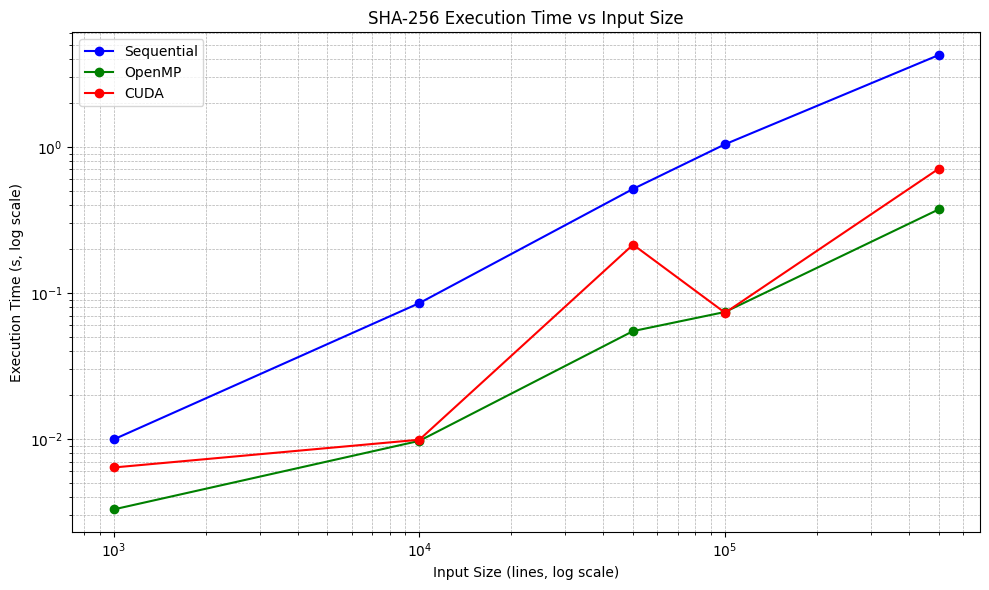

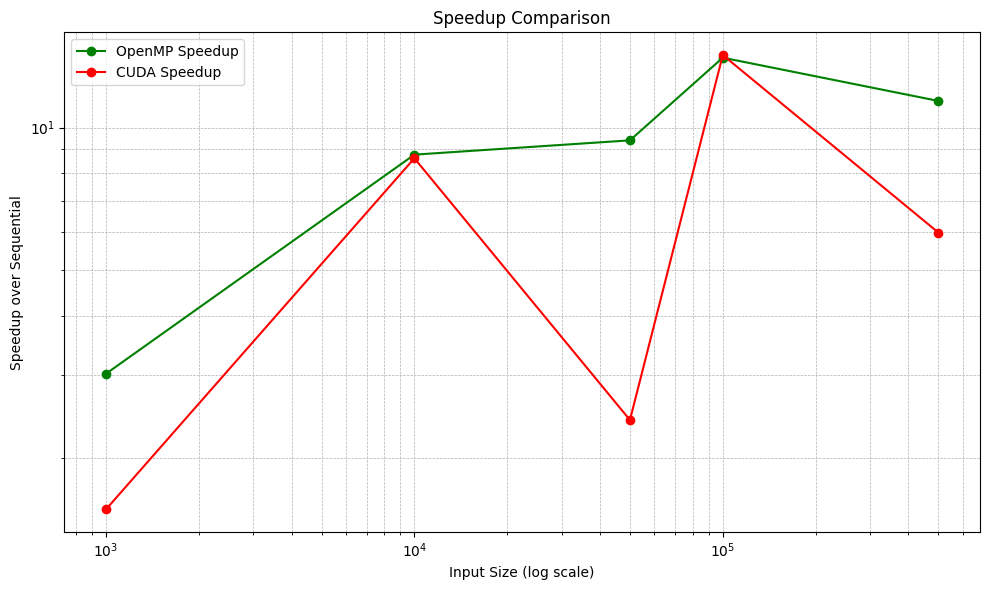

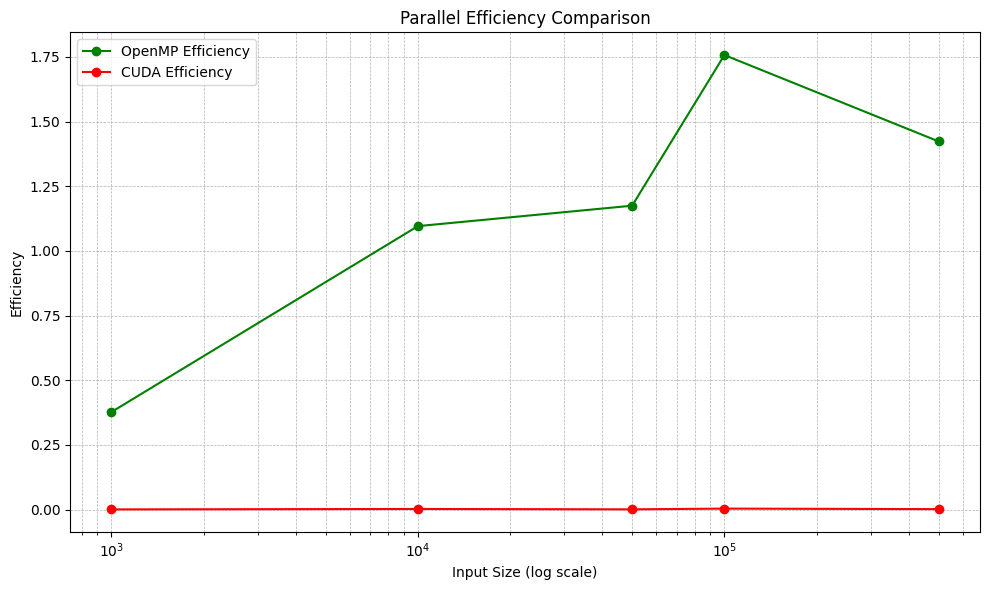

In [90]:
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt

# Paths
DATA_DIR = "sha256_project/data"
BIN_DIR = "sha256_project/build"
SRC_DIR = "sha256_project/src"
os.makedirs(DATA_DIR, exist_ok=True)

# Input sizes to benchmark (lines of text)
input_sizes = [10**3, 10**4, 5*10**4, 10**5, 5*10**5]

# Parallel parameters
OPENMP_THREADS = 8
CUDA_BLOCKS = 16
CUDA_THREADS = 256

def generate_input_file(n_lines, path):
    with open(path, "w") as f:
        for i in range(n_lines):
            f.write(f"Sample data line number {i}\n")

def run_binary(binary_path, input_path, print_output=False):
    try:
        result = subprocess.run([binary_path, input_path], capture_output=True, text=True, timeout=60)
        if result.returncode != 0:
            print(f"❌ Error running {binary_path}")
            print(result.stderr)
            return "Error", ""
        if print_output:
            # Print output including the hash values (assuming the program outputs input line + hash)
            print(f"\n📄 Output from {os.path.basename(binary_path)} for input file {input_path}:\n")
            print(result.stdout)
        return result.stdout.strip(), result.stderr
    except subprocess.TimeoutExpired:
        return "❌ Timeout", ""

# Compiled binaries (assumed to be built already)
BINARIES = {
    "Sequential": os.path.join(BIN_DIR, "sha256_seq"),
    "OpenMP":     os.path.join(BIN_DIR, "sha256_openmp"),
    "CUDA":       os.path.join(BIN_DIR, "sha256_cuda_streams")
}

# Results storage
sequential_times = []
openmp_times = []
cuda_times = []
speedups_openmp = []
speedups_cuda = []

for idx, size in enumerate(input_sizes):
    input_file = os.path.join(DATA_DIR, f"input_{size}.txt")
    generate_input_file(size, input_file)

    results = {}
    for name, binary in BINARIES.items():
        print_hashes = (idx == 0)  # Print only for smallest input
        output, _ = run_binary(binary, input_file, print_output=print_hashes)

        try:
            # Extract time from line containing 'Time:'
            time_line = [line for line in output.splitlines() if "Time:" in line][-1]
            time_value = float(time_line.split("Time:")[-1].split("s")[0].strip())
            results[name] = time_value
        except Exception as e:
            print(f"⚠️ Could not parse time for {name}: {e}")
            results[name] = float("inf")

    sequential_time = results["Sequential"]
    openmp_time = results["OpenMP"]
    cuda_time = results["CUDA"]

    sequential_times.append(sequential_time)
    openmp_times.append(openmp_time)
    cuda_times.append(cuda_time)

    speedups_openmp.append(sequential_time / openmp_time)
    speedups_cuda.append(sequential_time / cuda_time)

    print(f"\n{'Input Size':>10} | {'Sequential':>12} | {'OpenMP':>10} | {'CUDA':>10}")
    print("-" * 50)
    print(f"{size:10} | {sequential_time:12.5f} | {openmp_time:10.5f} | {cuda_time:10.5f}")

# Summary
avg_speedup_openmp = np.mean(speedups_openmp)
avg_speedup_cuda = np.mean(speedups_cuda)
efficiency_openmp = [s / OPENMP_THREADS for s in speedups_openmp]
efficiency_cuda = [s / (CUDA_BLOCKS * CUDA_THREADS) for s in speedups_cuda]
avg_eff_openmp = np.mean(efficiency_openmp)
avg_eff_cuda = np.mean(efficiency_cuda)

print("\n📊 Summary:")
print(f"Average Speedup (OpenMP): {avg_speedup_openmp:.2f}")
print(f"Average Speedup (CUDA):   {avg_speedup_cuda:.2f}")
print(f"Average Efficiency (OpenMP): {avg_eff_openmp:.4f}")
print(f"Average Efficiency (CUDA):   {avg_eff_cuda:.4f}")

# Plot 1: Execution Time
plt.figure(figsize=(10, 6))
plt.plot(input_sizes, sequential_times, label="Sequential", marker="o", color="blue")
plt.plot(input_sizes, openmp_times, label="OpenMP", marker="o", color="green")
plt.plot(input_sizes, cuda_times, label="CUDA", marker="o", color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Input Size (lines, log scale)")
plt.ylabel("Execution Time (s, log scale)")
plt.title("SHA-256 Execution Time vs Input Size")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 2: Speedup
plt.figure(figsize=(10, 6))
plt.plot(input_sizes, speedups_openmp, label="OpenMP Speedup", marker="o", color="green")
plt.plot(input_sizes, speedups_cuda, label="CUDA Speedup", marker="o", color="red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Input Size (log scale)")
plt.ylabel("Speedup over Sequential")
plt.title("Speedup Comparison")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# Plot 3: Efficiency
plt.figure(figsize=(10, 6))
plt.plot(input_sizes, efficiency_openmp, label="OpenMP Efficiency", marker="o", color="green")
plt.plot(input_sizes, efficiency_cuda, label="CUDA Efficiency", marker="o", color="red")
plt.xscale("log")
plt.xlabel("Input Size (log scale)")
plt.ylabel("Efficiency")
plt.title("Parallel Efficiency Comparison")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
